In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import scipy.linalg as la
import pandas as pd
import random as rand
from sklearn.model_selection import train_test_split

Helper Functions

In [22]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('submission.csv', index_label='Id')

def mean_and_sd(dat):
    """
    Takes a nxd matrix and returns the mean and stddev of each column feature.
    """
    return np.mean(np.array(dat), axis=0), np.std(np.array(dat), axis=0)

def normalize(dat, mu, sig):
    """
    Takes a nxd pandas df and returns a normalized version.
    """
    return dat.apply(lambda row: (row - mu)/sig, axis=1)

def logistic(x):
    return 1/(1+np.exp(-x))

def update_batch_gradient_descent(X, w, y, lamb, epsilon):
    return epsilon * (np.matmul(X.T, (y - logistic(np.matmul(X, w)))) - 2 * lamb * w)

def logistic_accuracy(val, w, y):
    y_pred = np.round(logistic(np.matmul(val, w)))
    return 1 - np.count_nonzero(y_pred - y)/len(y)

def update_stochastic_gradient_descent(Xi, w, yi, lamb, epsilon):
    return epsilon * ((yi - logistic(np.dot(Xi, w))) * Xi - 2 * lamb * w)

Organizing dataset

In [23]:
dat = io.loadmat('data.mat')
training_data = pd.DataFrame(dat["X"], columns=dat["description"])
labels = pd.DataFrame(dat["y"])
training, validation, y_train, y_val = train_test_split(training_data, labels, test_size=0.2, random_state=42)
training = training.reset_index(drop=True)
validation = validation.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

mu, sig = mean_and_sd(training)
training = normalize(training, mu, sig)
validation = normalize(validation, mu, sig)
training["Bias"] = 1
validation["Bias"] = 1

Implementing and analyzing the accuracy of batch gradient descent.

In [24]:
lamb = 0.01
epsilon = 0.01
num_iter = [10, 20, 100, 200, 500, 1000, 5000]
weights = []
for n in num_iter:
    w = np.zeros(training.shape[1])
    e = update_batch_gradient_descent(np.array(training), w, np.array(y_train).flatten(), lamb, epsilon)
    for i in range(n):
        w += e
        e = update_batch_gradient_descent(np.array(training), w, np.array(y_train).flatten(), lamb, epsilon)
    weights.append(w)

Text(0.5, 1.0, 'Accuracy as a function of Batch GD Iterations')

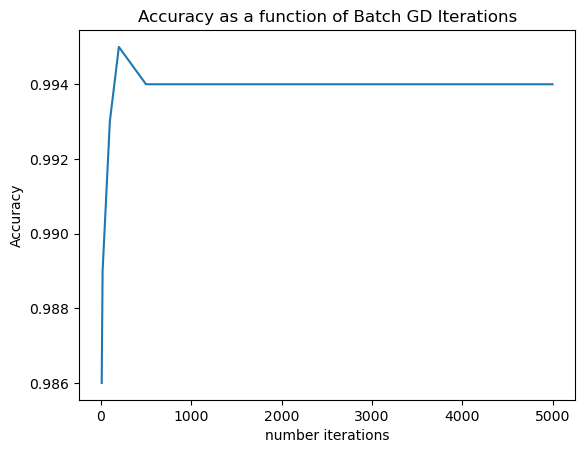

In [25]:
accuracies = []
for w in weights:
    accuracies.append(logistic_accuracy(np.array(validation), w, np.array(y_val).flatten()))

plt.plot(num_iter, accuracies)
plt.xlabel("number iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of Batch GD Iterations")

Implementing and analyzing the accuracy of stochastic gradient descent.

In [26]:
lamb = 0.01
epsilon = 0.01
num_iter = [10, 20, 100, 200, 500, 1000, 4000]
weights = []
for n in num_iter:
    w = np.zeros(training.shape[1])
    for i in range(n):
        e = update_stochastic_gradient_descent(np.array(training)[i], w, np.array(y_train).flatten()[i], lamb, epsilon)
        w += e
    weights.append(w)


Text(0.5, 1.0, 'Accuracy as a function of Stochastic GD Iterations')

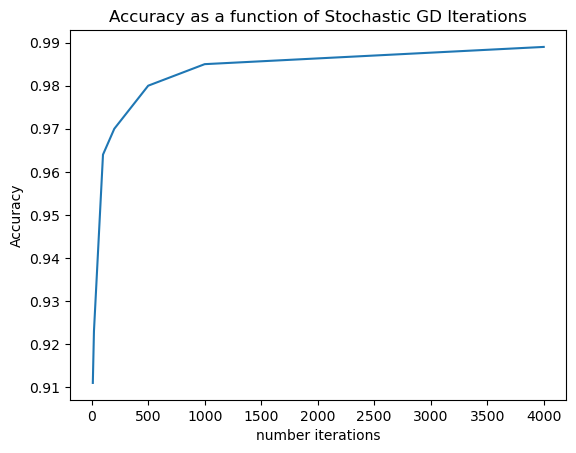

In [27]:
accuracies = []
for w in weights:
    accuracies.append(logistic_accuracy(np.array(validation), w, np.array(y_val).flatten()))

plt.plot(num_iter, accuracies)
plt.xlabel("number iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of Stochastic GD Iterations")

In [28]:
accuracies[-1]

0.989

Decreasing step size of stochastic GD as we approach the optimum.

In [29]:
lamb = 0.01
delta = 300
num_iter = [10, 20, 100, 200, 500, 1000, 4000]
weights = []
for n in num_iter:
    w = np.zeros(training.shape[1])
    for i in range(n):
        e = update_stochastic_gradient_descent(np.array(training)[i], w, np.array(y_train).flatten()[i], lamb, delta/(i+1))
        w += e
    weights.append(w)


/var/folders/b8/1d0pxr4s0_9fbr4rdryjb1000000gn/T/ipykernel_63416/3725418810.py:20: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Text(0.5, 1.0, 'Accuracy as a function of Changing Step Stochastic GD Iterations')

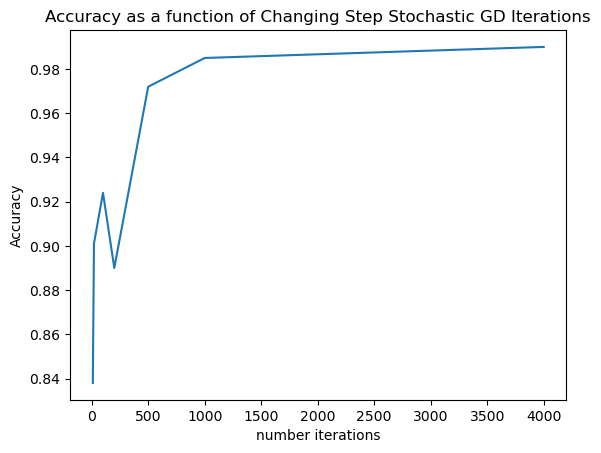

In [30]:
accuracies = []
for w in weights:
    accuracies.append(logistic_accuracy(np.array(validation), w, np.array(y_val).flatten()))

plt.plot(num_iter, accuracies)
plt.xlabel("number iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of Changing Step Stochastic GD Iterations")

In [31]:
accuracies[-1]

0.99

In [32]:
lamb = 0.005
delta = 300
num_iter = 4000
w
w = np.zeros(training.shape[1])
for i in range(n):
    e = update_stochastic_gradient_descent(np.array(training)[i], w, np.array(y_train).flatten()[i], lamb, delta/(i+1))
    w += e
w

/var/folders/b8/1d0pxr4s0_9fbr4rdryjb1000000gn/T/ipykernel_63416/3725418810.py:20: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


array([ 0.59579966,  0.96421766, -0.27228454, -0.69161958,  0.34316379,
       -0.15071574, -1.3997095 ,  1.12417523,  0.51398757,  0.7409758 ,
        0.3080205 ,  0.01424525, -1.91157127])

Using best model on test set for red/white wine classification.

In [33]:
test = pd.DataFrame(dat["X_test"], columns=dat["description"])
test = normalize(test, mu, sig)
test["Bias"] = 1
results_to_csv(np.round(logistic(np.matmul(test, w))))


In [34]:
test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Bias
0,-0.560354,-0.965203,0.094334,0.555946,-0.150157,-0.808130,0.283746,0.618933,0.366350,-0.614744,-1.515683,1.347864,1
1,0.146779,-1.148524,0.717798,-0.787987,-0.322505,1.023074,0.688289,-0.903510,-1.374917,0.459660,-0.091928,0.205122,1
2,0.068209,-0.598560,0.648524,1.750553,-0.178882,0.579146,1.110422,1.397071,0.926043,-0.681894,-0.678180,-0.937620,1
3,0.225350,1.479083,1.687631,-0.489336,2.779745,-1.418531,-1.774150,0.030255,-0.068967,3.347122,0.913074,0.205122,1
4,-0.638925,-0.537453,1.756905,-0.937313,0.165812,-0.530675,0.125446,-0.774948,-1.374917,-0.883345,-0.845681,-0.937620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.953206,-1.209631,0.371429,-0.894649,-0.695924,1.799949,0.582756,-0.954258,0.615103,-0.614744,0.578073,-0.937620,1
996,-1.346058,-0.354131,-0.736952,-0.809320,-0.695924,-0.419692,-0.525342,-1.488805,1.236984,-0.749045,1.666827,-0.937620,1
997,-0.717495,-1.209631,0.509976,-0.894649,-0.351229,-0.253219,0.019913,-0.903510,0.241974,-0.010392,-0.175679,0.205122,1
998,-0.324643,2.884548,-1.845333,-0.723991,0.395609,-1.363040,-1.774150,0.321211,1.796677,0.862562,0.243073,0.205122,1
